In [1]:
import json
from pprint import pprint
from typing import List, Dict
import pandas as pd
import requests
from bs4 import BeautifulSoup
from loguru import logger
from tqdm import tqdm
import re


### helper functions

In [2]:
def write_json(file_path, data):
    with open(file_path,'w',encoding='utf-8') as f:
        json.dump(data,f,indent=4)

def read_json(file_path):
    with open(file_path,encoding='utf-8') as f:
        data = json.load(f.read())
        return data

def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

def get_content(details_dict):    
    content = details_dict.get('data').get('attributes').get('content')
    content = striphtml(content)
    return content

## Get All transcripts List

In [12]:
def get_all_transcripts_list(size=20, api_key=None, ticker="SPGI"):
    url = "https://seeking-alpha.p.rapidapi.com/transcripts/v2/list"

    querystring = {"id":ticker,"size":size,"number":"1"}

    headers = {
    "X-RapidAPI-Key": "",
    "X-RapidAPI-Host": "seeking-alpha.p.rapidapi.com"
    }
    

    response = requests.request("GET", url, headers=headers, params=querystring)

    #print(response.text)
    result = response.text
    data = json.loads(result)
    print(data)
    #print(data)
    data = [dict_ for dict_ in data['data'] if dict_['type'] == 'transcript']
    for dict_ in data:
        dict_['ticker'] = ticker
    
    return data

## Get Details

In [4]:
def get_detail_transcript(transcripts_id, api_key=None):
    
    url = "https://seeking-alpha.p.rapidapi.com/transcripts/v2/get-details"

    querystring = {"id":str(transcripts_id)}

    headers = {
    "X-RapidAPI-Key": "",
    "X-RapidAPI-Host": "seeking-alpha.p.rapidapi.com"
    }

    response = requests.request("GET", url, headers=headers, params=querystring)
    content_dict = json.loads(response.text)
    return content_dict

    #return json.loads(json.dumps([dict1, dict2]))

# scraping for getting sector

In [5]:
def get_sp500():
    
    url = 'https://www.liberatedstocktrader.com/sp-500-companies-list-by-sector-market-cap/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, features="html.parser")
    table = soup.find( "table", {"style":"border-collapse: collapse;"})
    df = pd.read_html(str(table))[0]
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)
    return df

In [6]:
df_sp500_sector = get_sp500()

In [7]:
df_sp500_sector[df_sp500_sector['Ticker'] == 'AAPL']

,Ticker,Company,Sector,Market Capitalization,PE Ratio
58,AAPL,Apple Inc.,Electronic Technology,2122302102525,45.16039


In [8]:
def get_ticker_by_sector(sector):
    
    df_sp500_sector = get_sp500()
    selected_df = df_sp500_sector[df_sp500_sector['Sector'] == sector]
    ticker_list = selected_df['Ticker'].to_list()
    logger.info(f'length of ticker: {len(ticker_list)}')
    return ticker_list
    

In [9]:
def add_ticker_content(ticker):

    data = get_all_transcripts_list(size=10, ticker=ticker)
    print(data)
    trans_list = []
    
    for dict_ in data:
        
        try:
            id_ = dict_.get('id')
            
        except AttributeError:
            id_=''
        
        try:
            ticker = dict_.get('ticker')
            
        except AttributeError:
            ticker = ''
        
        try: 
            title = dict_.get('attributes').get('title')
            
        except AttributeError:
            title = ''
            
        try:
            
            date = dict_.get('attributes').get('publishOn')
            
        except AttributeError:
            date = ''
        
        try:
            transcript = get_detail_transcript(id_, api_key=None)
            content = get_content(transcript)
            
        except AttributeError:
            content = ''
                   

        transc_dict = {
            
            'ticker': ticker,
            'id': id_,
            'title': title,
            'date': date,
            'content': content
        }

        trans_list.append(transc_dict)
        logger.info(f'{ticker} transcript is done!')
        
    return trans_list
    

In [174]:


sector = 'Electronic Technology'
ticker_list = get_ticker_by_sector(sector)
selected_data = []

for ticker in tqdm(ticker_list):
    try:
        data_dict = add_ticker_content(ticker)
        for dict_ in data_dict:
            dict_['ticker'] = ticker
            dict_['sector'] = sector
        selected_data.extend(add_ticker_content(ticker))
        
    except Exception as e:
        raise Exception

2023-02-10 05:52:31.916 | INFO     | __main__:get_ticker_by_sector:6 - length of ticker: 52
  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

{'data': [{'id': '4563408', 'type': 'transcript', 'attributes': {'publishOn': '2022-12-08T21:42:01-05:00', 'isLockedPro': False, 'commentCount': 0, 'gettyImageUrl': None, 'videoPreviewUrl': None, 'themes': {}, 'title': 'Arista Networks, Inc. (ANET) Barclays 2022 Global Technology, Media and Telecommunications Conference (Transcript)', 'isPaywalled': False}, 'relationships': {'author': {'data': {'id': '44211', 'type': 'author'}}, 'sentiments': {'data': []}, 'primaryTickers': {'data': [{'id': '9916', 'type': 'tag'}]}, 'secondaryTickers': {'data': []}, 'otherTags': {'data': [{'id': '49', 'type': 'tag'}]}}, 'links': {'self': '/article/4563408-arista-networks-inc-anet-barclays-2022-global-technology-media-and-telecommunications'}}, {'id': '4563008', 'type': 'transcript', 'attributes': {'publishOn': '2022-12-07T13:33:03-05:00', 'isLockedPro': False, 'commentCount': 0, 'gettyImageUrl': None, 'videoPreviewUrl': None, 'themes': {}, 'title': 'Arista Networks, Inc. (ANET) Management presents at 2

  0%|                                                                                           | 0/52 [00:05<?, ?it/s]


Exception: 

In [173]:
[dict_ for dict_ in selected_data if dict_['ticker'] == 'AAPL'][0]

{'ticker': 'AAPL',
 'id': '4574934',
 'title': 'Apple, Inc. (AAPL) Q1 2023 Earnings Call Transcript',
 'date': '2023-02-02T21:33:03-05:00',
 'content': "Apple, Inc. (NASDAQ:AAPL) Q1 2023 Earnings Conference Call February 2, 2023 5:00 PM ET Company Participants Tejas Gala - IR Contact Timothy Cook - CEO &amp; Director Luca Maestri - CFO &amp; SVP Conference Call Participants David Vogt - UBS Shannon Cross - Crédit Suisse Erik Woodring - Morgan Stanley Aaron Rakers - Wells Fargo Securities Krish Sankar - Cowen and Company Wamsi Mohan - Bank of America Merrill Lynch Amit Daryanani - Evercore ISI Harsh Kumar - Piper Sandler &amp; Co. James Suva - Citigroup Operator Good day, everyone, and welcome to the Apple Q1 Fiscal Year 2023 Earnings Conference Call. Today's call is being recorded.  And now at this time, for opening remarks and introductions, I would like to turn the call over to Tejas Gala, Director of Investor Relations and Corporate Finance. Please go ahead. Tejas Gala Thank you. Sp

In [ ]:
write_json('Finance.json', selected_sector)

In [32]:
df = pd.DataFrame(selected_data)

In [33]:
df

,ticker,id,title,date,content
0,ANET,4563408,"Arista Networks, Inc. (ANET) Barclays 2022 Glo...",2022-12-08T21:42:01-05:00,"Arista Networks, Inc. (NYSE:ANET) Barclays 202..."
1,ANET,4563008,"Arista Networks, Inc. (ANET) Management presen...",2022-12-07T13:33:03-05:00,"Arista Networks, Inc. (NYSE:ANET) 2022 Raymond..."
2,ANET,4562795,"Arista Networks, Inc. (ANET) Management presen...",2022-12-06T18:43:04-05:00,"Arista Networks, Inc. (NYSE:ANET) UBS 50th Ann..."
3,ANET,4561617,"Arista Networks, Inc. (ANET) Wells Fargo 6th A...",2022-11-30T22:55:02-05:00,"Arista Networks, Inc. (NYSE:ANET) Wells Fargo ..."
4,ANET,4561207,"Arista Networks, Inc. (ANET) Presents at Credi...",2022-11-29T15:28:02-05:00,"Arista Networks, Inc. (NYSE:ANET) Credit Suiss..."
...,...,...,...,...,...
104,TXN,4516071,Texas Instruments Incorporated's (TXN) CEO Ric...,2022-06-02T13:42:06-04:00,Texas Instruments Incorporated (NASDAQ:TXN) Be...
105,TXN,4503805,Texas Instruments Incorporated (TXN) Managemen...,2022-04-26T17:44:02-04:00,Texas Instruments Incorporated (NASDAQ:TXN) Q1...
106,TXN,4494196,Texas Instruments Incorporated (TXN) CEO Rich ...,2022-03-09T15:16:03-05:00,Texas Instruments Incorporated (NASDAQ:TXN) Mo...
107,TXN,4481591,Texas Instruments Incorporated (TXN) Managemen...,2022-01-25T17:27:09-05:00,Texas Instruments Incorporated (NASDAQ:TXN) Q4...


In [20]:
apple = df[df['ticker'] == 'AAPL']

In [36]:
apple

,ticker,id,title,date,content,num_words,Date,num_char
23,AAPL,4574934,"Apple, Inc. (AAPL) Q1 2023 Earnings Call Trans...",2023-02-02T21:33:03-05:00,"Apple, Inc. (NASDAQ:AAPL) Q1 2023 Earnings Con...",8968,2023-02-02,46073
24,AAPL,4550156,Apple Inc. (AAPL) Q4 2022 Earnings Call Transc...,2022-10-27T19:46:03-04:00,Apple Inc. (NASDAQ:AAPL) Q4 2022 Earnings Conf...,9257,2022-10-27,47500
25,AAPL,4527231,"Apple, Inc. (AAPL) CEO Tim Cook on Q3 2022 Res...",2022-07-28T21:11:05-04:00,"Apple, Inc. (NASDAQ:AAPL) Q3 2022 Earnings Con...",9059,2022-07-28,46934
26,AAPL,4504834,Apple Inc. (AAPL) CEO Tim Cook on Q2 2022 Resu...,2022-04-28T19:21:03-04:00,Apple Inc. (NASDAQ:AAPL) Q2 2022 Earnings Conf...,9269,2022-04-28,47757
27,AAPL,4482308,Apple Inc. (AAPL) CEO Tim Cook on Q1 2022 Resu...,2022-01-27T20:19:05-05:00,Apple Inc. (NASDAQ:AAPL) Q1 2022 Earnings Conf...,8948,2022-01-27,45252
28,AAPL,4463261,Apple Inc. (AAPL) CEO Tim Cook on Q4 2021 Resu...,2021-10-28T21:25:05-04:00,Apple Inc. (NASDAQ:AAPL) Q4 2021 Results Confe...,9976,2021-10-28,49257
29,AAPL,4441901,Apple Inc. (AAPL) CEO Tim Cook on Q3 2021 Resu...,2021-07-27T23:13:05-04:00,Apple Inc. (NASDAQ:AAPL) Q3 2021 Earnings Conf...,9839,2021-07-27,49362
30,AAPL,4422230,Apple Inc. (AAPL) CEO Tim Cook on Q2 2021 Resu...,2021-04-28T21:17:11-04:00,Apple Inc. (NASDAQ:AAPL) Q2 2021 Results Confe...,9532,2021-04-28,48179
31,AAPL,4401478,Apple Inc. (AAPL) CEO Tim Cook on Q1 2021 Resu...,2021-01-27T20:48:03-05:00,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,9599,2021-01-27,48203
32,AAPL,4382943,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,2020-10-29T23:40:53-04:00,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,9860,2020-10-29,49532


In [29]:
from nltk.tokenize import word_tokenize
def num_words(text):
    words = word_tokenize(text)
    return len(words)

apple['num_words'] = apple['content'].apply(num_words)

def get_date(text):
    date_pattern = r"\d{4}-\d{2}-\d{2}"
    date = ''.join(re.findall(date_pattern, text))
    return date

apple['Date'] = apple['date'].apply(get_date)
apple['Date'] = pd.to_datetime(apple['Date'])


def num_char(text):
    return len(text)
apple['num_char'] = apple['content'].apply(num_char)

C:\Users\user\AppData\Local\Temp\ipykernel_27728\1782164281.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_27728\1782164281.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\user\AppData\Local\Temp\ipykernel_27728\1782164281.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [24]:
apple

,ticker,id,title,date,content,num_words,Date
23,AAPL,4574934,"Apple, Inc. (AAPL) Q1 2023 Earnings Call Trans...",2023-02-02T21:33:03-05:00,"Apple, Inc. (NASDAQ:AAPL) Q1 2023 Earnings Con...",8968,2023-02-02
24,AAPL,4550156,Apple Inc. (AAPL) Q4 2022 Earnings Call Transc...,2022-10-27T19:46:03-04:00,Apple Inc. (NASDAQ:AAPL) Q4 2022 Earnings Conf...,9257,2022-10-27
25,AAPL,4527231,"Apple, Inc. (AAPL) CEO Tim Cook on Q3 2022 Res...",2022-07-28T21:11:05-04:00,"Apple, Inc. (NASDAQ:AAPL) Q3 2022 Earnings Con...",9059,2022-07-28
26,AAPL,4504834,Apple Inc. (AAPL) CEO Tim Cook on Q2 2022 Resu...,2022-04-28T19:21:03-04:00,Apple Inc. (NASDAQ:AAPL) Q2 2022 Earnings Conf...,9269,2022-04-28
27,AAPL,4482308,Apple Inc. (AAPL) CEO Tim Cook on Q1 2022 Resu...,2022-01-27T20:19:05-05:00,Apple Inc. (NASDAQ:AAPL) Q1 2022 Earnings Conf...,8948,2022-01-27
28,AAPL,4463261,Apple Inc. (AAPL) CEO Tim Cook on Q4 2021 Resu...,2021-10-28T21:25:05-04:00,Apple Inc. (NASDAQ:AAPL) Q4 2021 Results Confe...,9976,2021-10-28
29,AAPL,4441901,Apple Inc. (AAPL) CEO Tim Cook on Q3 2021 Resu...,2021-07-27T23:13:05-04:00,Apple Inc. (NASDAQ:AAPL) Q3 2021 Earnings Conf...,9839,2021-07-27
30,AAPL,4422230,Apple Inc. (AAPL) CEO Tim Cook on Q2 2021 Resu...,2021-04-28T21:17:11-04:00,Apple Inc. (NASDAQ:AAPL) Q2 2021 Results Confe...,9532,2021-04-28
31,AAPL,4401478,Apple Inc. (AAPL) CEO Tim Cook on Q1 2021 Resu...,2021-01-27T20:48:03-05:00,Apple Inc. (NASDAQ:AAPL) Q1 2021 Results Confe...,9599,2021-01-27
32,AAPL,4382943,Apple Inc. (AAPL) CEO Tim Cook on Q4 2020 Resu...,2020-10-29T23:40:53-04:00,Apple Inc. (NASDAQ:AAPL) Q4 2020 Earnings Conf...,9860,2020-10-29


In [100]:
import plotly.express as px

fig = px.bar(apple, y='num_words', x='Date', text_auto='.2s',color='num_words',
            title='Number of words per Apple Transcript Call',
            hover_data=['ticker', 'title', 'Date', 'num_words'])
fig.show()

In [175]:
import plotly.express as px

fig = px.bar(apple, y='num_char', x='Date', text_auto='.2s',color='num_char',
            title='Number of char per Apple Transcript Call',
            hover_data=['ticker', 'title', 'Date', 'num_words'])
fig.show()

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(10,10), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown','year', 'think', 'look', 'thank'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

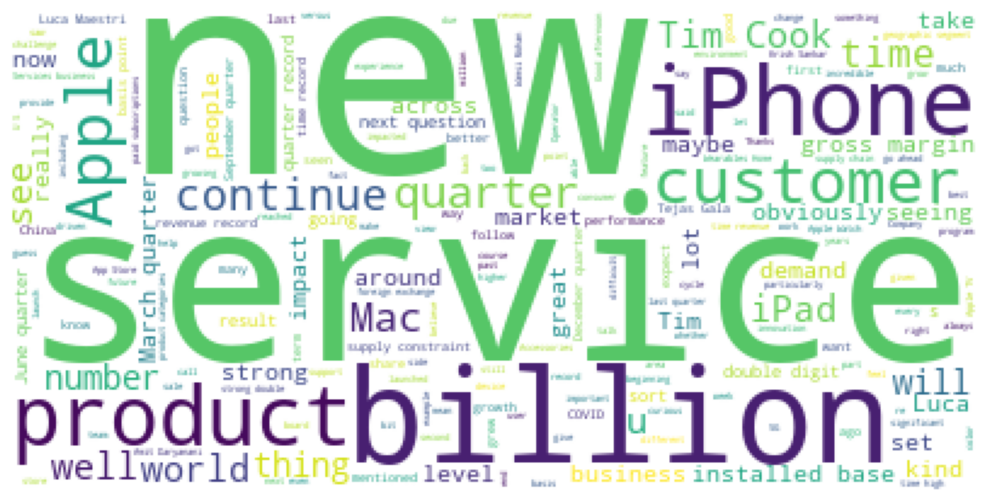

In [52]:
content_apple = ' '.join(apple['content'].to_list())

plot_wordcloud(content_apple)

In [60]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from collections import Counter
import itertools 
from pathlib import Path
from loguru import logger
from tqdm import tqdm

from utils import read_json
# from text_preprocessing import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [55]:
from collections import Counter
from nltk.corpus import stopwords


In [66]:
def preprocessing(text):
    
    #convert all to lowercase
    text = text.lower()

    #removing puntuations
    text = re.sub(r'[^\w\s]', ' ', text)

    #remove stopwords
    word_token = [word for word in word_tokenize(text) \
                  if word.isalpha() and word not in stopwords.words('english')]

#     #stemizing
#     stemmer = PorterStemmer()
#     stem_word = [stemmer.stem(word) for word in word_token]



    #lemmitizing
    wnl = WordNetLemmatizer()
    lema_word = [wnl.lemmatize(word) for word in word_token]

    return ' '.join(lema_word)
    

In [67]:
content_apple = preprocessing(content_apple)

In [68]:
words = word_tokenize(content_apple)

In [92]:
top30 = Counter(words).most_common(20)

In [93]:
words_list = [i[0] for i in top30]
count_list = [i[1] for i in top30]

In [94]:
px.colors.qualitative.Plotly

['#636EFA',
 '#EF553B',
 '#00CC96',
 '#AB63FA',
 '#FFA15A',
 '#19D3F3',
 '#FF6692',
 '#B6E880',
 '#FF97FF',
 '#FECB52']

In [177]:
import plotly.express as px

fig = px.bar(y=words_list, x=count_list, color=words_list,
            title='Most Frequency Words in 10 Latest Apple Earnings Calls',
            labels={
                     "x": "Number of Words",
                     "y": "Words",
            }
             ,)
fig.show()

In [101]:
import spacy

In [109]:
nlp = spacy.load('en_core_web_md')

In [117]:
## for Example for last earnings call
apple_feb_content = apple.iloc[0]['content']
doc = nlp(apple_feb_content)

In [122]:
ner_list = []
for ent in doc.ents:
    ner_dict = {ent.label_:ent.text}
    ner_list.append(ner_dict)

In [125]:
ner_list

[{'ORG': 'Apple, Inc.'},
 {'ORG': 'NASDAQ'},
 {'ORG': 'AAPL'},
 {'DATE': 'Q1 2023'},
 {'DATE': 'February 2'},
 {'TIME': '5:00 PM'},
 {'PERSON': 'Timothy Cook -'},
 {'ORG': 'CEO &amp'},
 {'PERSON': 'Luca Maestri - CFO &'},
 {'PERSON': 'David Vogt - UBS'},
 {'PERSON': 'Erik Woodring - Morgan Stanley'},
 {'PERSON': 'Aaron Rakers -'},
 {'PERSON': 'Krish Sankar - Cowen'},
 {'PERSON': 'Wamsi Mohan - Bank of America'},
 {'PERSON': 'Harsh Kumar - Piper Sandler &amp'},
 {'ORG': 'Co.'},
 {'PERSON': 'James Suva - Citigroup'},
 {'LAW': 'the Apple Q1 Fiscal Year 2023 Earnings Conference Call'},
 {'DATE': 'Today'},
 {'EVENT': 'Tejas Gala'},
 {'ORG': 'Investor Relations and Corporate Finance'},
 {'PERSON': 'Tejas Gala'},
 {'ORDINAL': 'first'},
 {'ORG': 'Apple'},
 {'PERSON': 'Tim Cook'},
 {'PERSON': 'Luca Maestri'},
 {'PERSON': 'Tim'},
 {'DATE': 'December quarter'},
 {'DATE': '14 weeks'},
 {'DATE': 'the March quarter'},
 {'DATE': '13 weeks'},
 {'DATE': 'today'},
 {'ORG': 'Apple'},
 {'DATE': 'annual'},

In [127]:
[dict_ for dict_ in ner_list if list(dict_.keys())[0] == 'ORG']

[{'ORG': 'Apple, Inc.'},
 {'ORG': 'NASDAQ'},
 {'ORG': 'AAPL'},
 {'ORG': 'CEO &amp'},
 {'ORG': 'Co.'},
 {'ORG': 'Investor Relations and Corporate Finance'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'SEC'},
 {'ORG': 'Apple'},
 {'ORG': 'iPhone 14 Pro'},
 {'ORG': 'iPhone 14 Pro'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'iPhone'},
 {'ORG': 'M1 MacBook Pros'},
 {'ORG': 'Apple'},
 {'ORG': 'Mac'},
 {'ORG': 'iPad'},
 {'ORG': 'iPad Pro'},
 {'ORG': 'HomePod'},
 {'ORG': 'HomePod'},
 {'ORG': 'Apple Watch Series'},
 {'ORG': 'Apple Watch Ultra'},
 {'ORG': 'SOS'},
 {'ORG': 'iPad'},
 {'ORG': 'Mac'},
 {'ORG': 'App Store'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'Major League Soccer'},
 {'ORG': 'MLS Season Pass'},
 {'ORG': 'MLS'},
 {'ORG': 'MLS Cup'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'Spirited'},
 {'ORG': 'Time to Walk'},
 {'ORG': 'Apple Business Connect'},
 {'ORG': 'Apple Maps'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple Pacific Centre'},
 {'ORG': 'Apple American Dream'},
 {

In [128]:
[list(dict_.keys()) for dict_ in ner_list]

[['ORG'],
 ['ORG'],
 ['ORG'],
 ['DATE'],
 ['DATE'],
 ['TIME'],
 ['PERSON'],
 ['ORG'],
 ['PERSON'],
 ['PERSON'],
 ['PERSON'],
 ['PERSON'],
 ['PERSON'],
 ['PERSON'],
 ['PERSON'],
 ['ORG'],
 ['PERSON'],
 ['LAW'],
 ['DATE'],
 ['EVENT'],
 ['ORG'],
 ['PERSON'],
 ['ORDINAL'],
 ['ORG'],
 ['PERSON'],
 ['PERSON'],
 ['PERSON'],
 ['DATE'],
 ['DATE'],
 ['DATE'],
 ['DATE'],
 ['DATE'],
 ['ORG'],
 ['DATE'],
 ['LAW'],
 ['ORG'],
 ['DATE'],
 ['ORG'],
 ['PERSON'],
 ['PERSON'],
 ['GPE'],
 ['TIME'],
 ['DATE'],
 ['MONEY'],
 ['DATE'],
 ['GPE'],
 ['GPE'],
 ['GPE'],
 ['GPE'],
 ['GPE'],
 ['GPE'],
 ['DATE'],
 ['GPE'],
 ['GPE'],
 ['PERCENT'],
 ['DATE'],
 ['DATE'],
 ['CARDINAL'],
 ['DATE'],
 ['ORDINAL'],
 ['DATE'],
 ['ORDINAL'],
 ['DATE'],
 ['ORG'],
 ['CARDINAL'],
 ['PRODUCT'],
 ['DATE'],
 ['ORG'],
 ['CARDINAL'],
 ['PRODUCT'],
 ['ORDINAL'],
 ['LOC'],
 ['ORG'],
 ['ORG'],
 ['MONEY'],
 ['DATE'],
 ['PERCENT'],
 ['DATE'],
 ['ORG'],
 ['CARDINAL'],
 ['DATE'],
 ['PERSON'],
 ['MONEY'],
 ['DATE'],
 ['ORG'],
 ['PERSON'],
 ['D

In [131]:
import itertools

set_ner = set(list(itertools.chain.from_iterable([list(dict_.keys()) for dict_ in ner_list])))

In [132]:
[dict_ for dict_ in ner_list if list(dict_.keys())[0] in set_ner]

[{'ORG': 'Apple, Inc.'},
 {'ORG': 'NASDAQ'},
 {'ORG': 'AAPL'},
 {'ORG': 'CEO &amp'},
 {'ORG': 'Co.'},
 {'ORG': 'Investor Relations and Corporate Finance'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'SEC'},
 {'ORG': 'Apple'},
 {'ORG': 'iPhone 14 Pro'},
 {'ORG': 'iPhone 14 Pro'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'iPhone'},
 {'ORG': 'M1 MacBook Pros'},
 {'ORG': 'Apple'},
 {'ORG': 'Mac'},
 {'ORG': 'iPad'},
 {'ORG': 'iPad Pro'},
 {'ORG': 'HomePod'},
 {'ORG': 'HomePod'},
 {'ORG': 'Apple Watch Series'},
 {'ORG': 'Apple Watch Ultra'},
 {'ORG': 'SOS'},
 {'ORG': 'iPad'},
 {'ORG': 'Mac'},
 {'ORG': 'App Store'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'Major League Soccer'},
 {'ORG': 'MLS Season Pass'},
 {'ORG': 'MLS'},
 {'ORG': 'MLS Cup'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple'},
 {'ORG': 'Spirited'},
 {'ORG': 'Time to Walk'},
 {'ORG': 'Apple Business Connect'},
 {'ORG': 'Apple Maps'},
 {'ORG': 'Apple'},
 {'ORG': 'Apple Pacific Centre'},
 {'ORG': 'Apple American Dream'},
 {

In [148]:
dict_2 = {}
for i in set_ner:
    dict_2[i] = [list(dict_.values()) for dict_ in ner_list if list(dict_.keys())[0] == i]

In [159]:
final_ner_dict = {key: list(set(list(itertools.chain.from_iterable(value)))) for key, value in dict_2.items() }

In [169]:
pd.DataFrame.from_dict(final_ner_dict, orient='index').fillna('').T

,ORDINAL,GPE,MONEY,PERCENT,LOC,PERSON,NORP,LAW,EVENT,CARDINAL,FAC,DATE,PRODUCT,ORG,WORK_OF_ART,TIME
0,third,India,$19 billion,43%,Greater China,Luca Maestri - CFO &,Chinese,iPad 10th Generation,Tejas Gala,3,Shannon,the 14th week,M1 Max,MLS,"Shrinking, Slow Horses and Truth Be Told",5:00 PM
1,Second,Indonesia,0.23,70.8%,Americas,Emmy Award,,the Apple Q1 Fiscal Year 2023 Earnings Confere...,Chinese New Year,more than 700,,the December quarter a year ago,M1 Pro,Bank of America,,afternoon
2,First,U.K.,$117.2 billion,43.5%,Eastern Europe,Tim,,Form 10-K,Black History Month,50,,early November,M2 Pro,AAPL,,approximately 5 p.m. Pacific Time
3,second,China,$3.8 billion,7%,Asia Pacific,Ted Lasso,,,,669,,February 2,MacBook Pro,Mars Incorporated,,
4,Third,Brazil,$9.4 billion,37%,Europe,Harsh Kumar - Piper Sandler &amp,,,,14,,25 years,M2,Apple Watch,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,,,,,,,,,,,,the last several years,,,,
75,,,,,,,,,,,,the holiday shopping season,,,,
76,,,,,,,,,,,,December quarter year-over-year,,,,
77,,,,,,,,,,,,just 5 years ago,,,,


In [164]:
import json

In [165]:
with open('ner.json', 'w') as f:
    json.dump(final_ner_dict, f, indent=4)

In [170]:
from spacy import displacy

In [172]:
displacy.serve(doc, style='ent')


Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.
